In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
data_path = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectricCompany/data/electric.csv"
raw_df = pl.read_csv(data_path).drop(["supp", ""])

raw_df.head()

post_test,pre_test,grade,treatment,pair_id
f64,f64,i64,i64,i64
48.9,13.8,1,1,1
70.5,16.5,1,1,2
89.7,18.5,1,1,3
44.2,8.8,1,1,4
77.5,15.3,1,1,5


/Users/juan.orduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


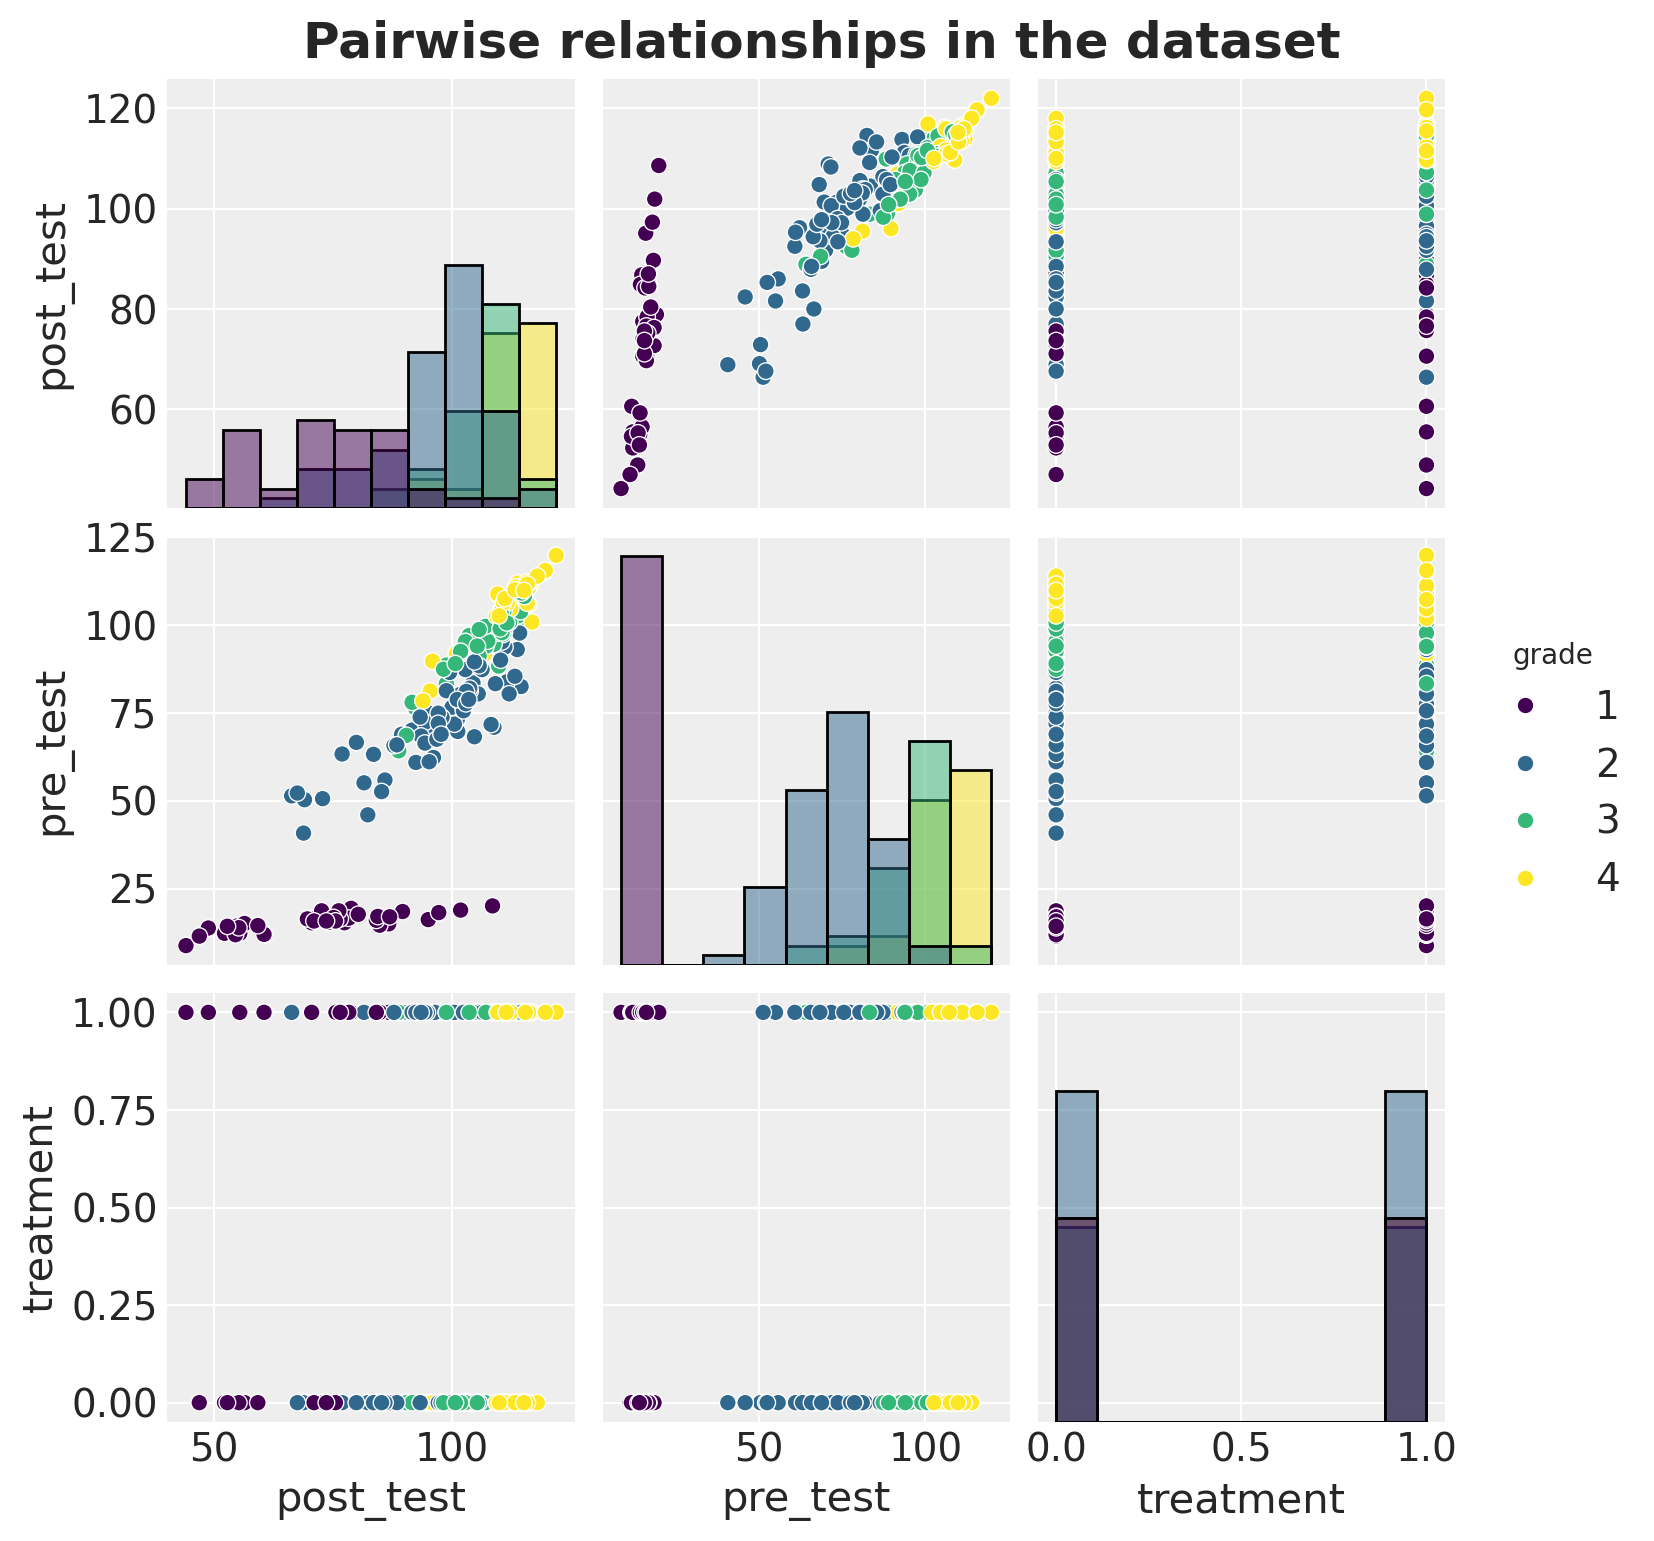

In [45]:
g = sns.pairplot(
    raw_df.drop(["pair_id"]).to_pandas(),
    hue="grade",
    diag_kind="hist",
    palette="viridis",
)
g.fig.suptitle(
    "Pairwise relationships in the dataset", fontsize=18, fontweight="bold", y=1.02
);

In [46]:
numeric_features = ["pre_test", "post_test"]
categorical_features = ["grade", "pair_id"]

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), numeric_features),
        ("cat", OrdinalEncoder(dtype=int), categorical_features),
    ],
    remainder="passthrough",
).set_output(transform="polars")


df = preprocessor.fit_transform(raw_df.sort(["pair_id", "grade"]))
df.columns = [col.split("__")[-1] for col in df.columns]

df.head()

pre_test,post_test,grade,pair_id,treatment
f64,f64,i64,i64,i64
-1.726248,-2.724052,0,0,1
-1.770568,-2.532096,0,0,0
-1.646472,-1.504567,0,1,1
-1.70852,-2.37966,0,1,0
-1.587379,-0.42058,0,2,1


In [ ]:
n_grades = len(preprocessor["cat"].categories_[categorical_features.index("grade")])
n_pairs = len(preprocessor["cat"].categories_[categorical_features.index("pair_id")])
n_instances = 2

coords = {
    # covariate index
    "grade": preprocessor["cat"].categories_[categorical_features.index("grade")],
    # object categories (groups)
    "pair_id": preprocessor["cat"].categories_[categorical_features.index("pair_id")],
    # dimension latent confounder
    "instance": np.arange(n_instances),
    # index
    "obs_idx": np.arange(len(df)),
}

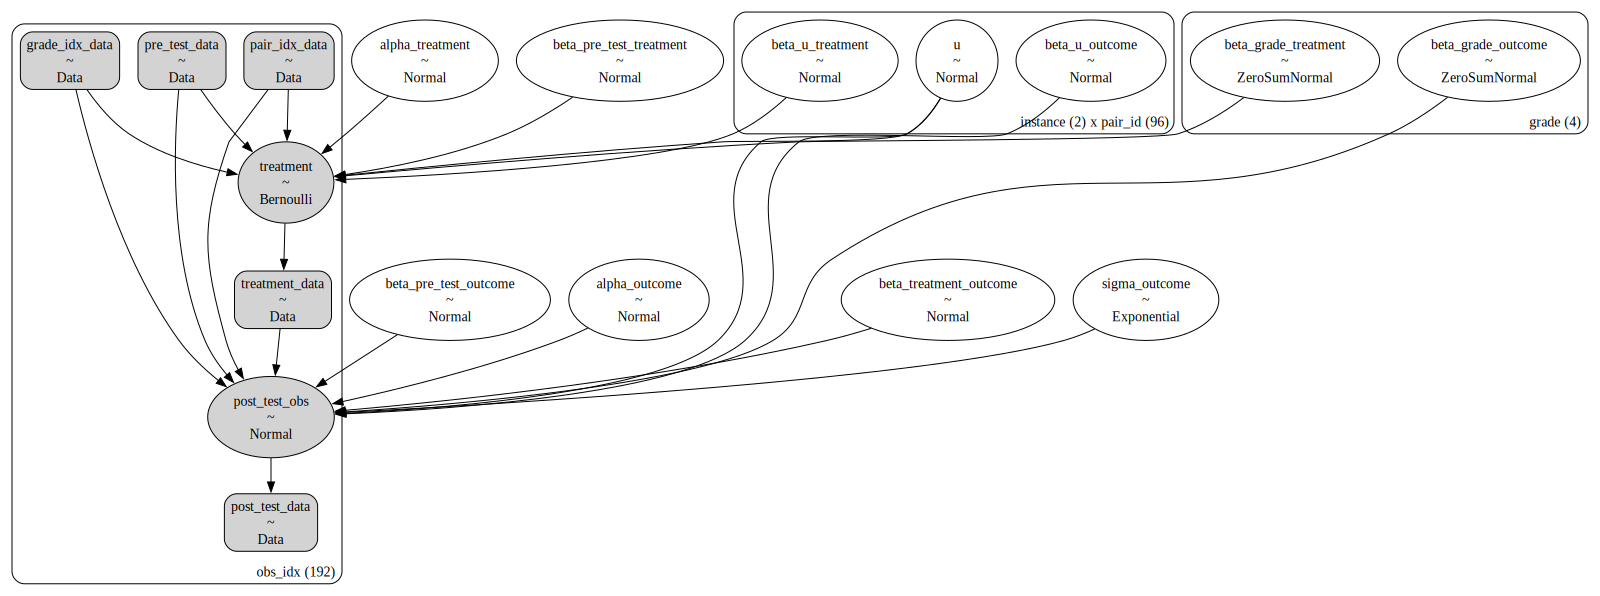

In [122]:
with pm.Model(coords=coords) as model:
    # --- Data Containers ---
    # covariates
    grade_idx_data = pm.Data("grade_idx_data", df["grade"].to_numpy(), dims="obs_idx")
    pre_test_data = pm.Data("pre_test_data", df["pre_test"].to_numpy(), dims="obs_idx")
    # object categories
    pair_idx_data = pm.Data("pair_idx_data", df["pair_id"].to_numpy(), dims="obs_idx")
    # treatment
    treatment_data = pm.Data(
        "treatment_data", df["treatment"].to_numpy(), dims="obs_idx"
    )
    # outcome
    post_test_data = pm.Data(
        "post_test_data", df["post_test"].to_numpy(), dims="obs_idx"
    )

    # --- Priors ---
    # latent confounder
    u = pm.Normal("u", mu=0, sigma=1, dims=("instance", "pair_id"))
    # treatment model
    alpha_treatment = pm.Normal("alpha_treatment", mu=0, sigma=1)
    beta_grade_treatment = pm.ZeroSumNormal("beta_grade_treatment", dims=("grade"))
    beta_pre_test_treatment = pm.Normal("beta_pre_test_treatment", mu=0, sigma=1)
    beta_u_treatment = pm.Normal(
        "beta_u_treatment", mu=0, sigma=1, dims=("instance", "pair_id")
    )
    # outcome model
    alpha_outcome = pm.Normal("alpha_outcome", mu=0, sigma=1)
    beta_grade_outcome = pm.ZeroSumNormal("beta_grade_outcome", dims=("grade"))
    beta_pre_test_outcome = pm.Normal("beta_pre_test_outcome", mu=0, sigma=1)
    beta_u_outcome = pm.Normal(
        "beta_u_outcome", mu=0, sigma=1, dims=("instance", "pair_id")
    )
    beta_treatment_outcome = pm.Normal("beta_treatment_outcome", mu=0, sigma=1)
    sigma_outcome = pm.Exponential("sigma_outcome", lam=1)

    # --- Parametrization ---
    p_treatment_raw = (
        alpha_treatment
        + beta_grade_treatment[grade_idx_data]
        + beta_pre_test_treatment * pre_test_data
        + ((beta_u_treatment * u)[:, pair_idx_data]).sum(axis=0)
    )

    p_treatment = pm.math.sigmoid(p_treatment_raw)

    treatment = pm.Bernoulli(
        "treatment", p=p_treatment, observed=treatment_data, dims="obs_idx"
    )

    mu_outcome = (
        alpha_outcome
        + beta_grade_outcome[grade_idx_data]
        + beta_pre_test_outcome * pre_test_data
        + ((beta_u_outcome * u)[:, pair_idx_data]).sum(axis=0)
        + beta_treatment_outcome * treatment_data
    )

    # --- Likelihood ---
    pm.Normal(
        "post_test_obs",
        mu=mu_outcome,
        sigma=sigma_outcome,
        observed=post_test_data,
        dims="obs_idx",
    )


pm.model_to_graphviz(model)

In [116]:
((beta_u_treatment * u)[:, pair_idx_data].sum(axis=0)).eval().shape

(192,)

(2, 192)